In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import glob

# Configuration
IMAGE_SIZE = 75  # Keep small for speed
BATCH_SIZE = 32
EPOCHS = 5

# 1. Locate the CSV file inside the downloaded path
# We look for the metadata file within the path kagglehub provided
csv_path = os.path.join(path, 'HAM10000_metadata.csv')
metadata = pd.read_csv(csv_path)

# 2. Locate all image files recursively inside the path
# This handles cases where images are split into part_1 and part_2 folders
image_paths = glob.glob(os.path.join(path, '**', '*.jpg'), recursive=True)

# Create a dictionary: Image ID -> Full File Path
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

# Map the paths to the dataframe
metadata['path'] = metadata['image_id'].map(image_path_dict)

# 3. Process Labels
label_mapping = {
    'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6
}
metadata['label_idx'] = metadata['dx'].map(label_mapping)

# 4. Load and Resize Images
print("Loading and resizing images... this may take 1-2 minutes.")
# Drop any rows where the image path wasn't found (safety check)
metadata = metadata.dropna(subset=['path'])

metadata['image'] = metadata['path'].map(
    lambda x: np.asarray(Image.open(x).resize((IMAGE_SIZE, IMAGE_SIZE)))
)

# 5. Prepare Training Data
X = np.asarray(metadata['image'].tolist()) / 255.0  # Normalize pixel values
Y = to_categorical(metadata['label_idx'], num_classes=7)

# Split into Train and Test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

print(f"Data ready! Training samples: {len(x_train)}, Test samples: {len(x_test)}")

Loading and resizing images... this may take 1-2 minutes.
Data ready! Training samples: 8012, Test samples: 2003


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax') # 7 output classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
print("Starting training...")
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test), batch_size=BATCH_SIZE)
print("Training finished!")

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 309ms/step - accuracy: 0.6538 - loss: 1.1114 - val_accuracy: 0.6690 - val_loss: 0.9147
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.6666 - loss: 0.9647 - val_accuracy: 0.6710 - val_loss: 0.8926
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 294ms/step - accuracy: 0.6914 - loss: 0.8906 - val_accuracy: 0.6770 - val_loss: 0.8703
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 290ms/step - accuracy: 0.6839 - loss: 0.8742 - val_accuracy: 0.6775 - val_loss: 0.8652
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 71s 284ms/step - accuracy: 0.6928 - loss: 0.8353 - val_accuracy: 0.6985 - val_loss: 0.8206
Training finished!


Upload an image of a skin mole/lesion to test:


Saving Screenshot 2026-01-19 231136.png to Screenshot 2026-01-19 231136.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


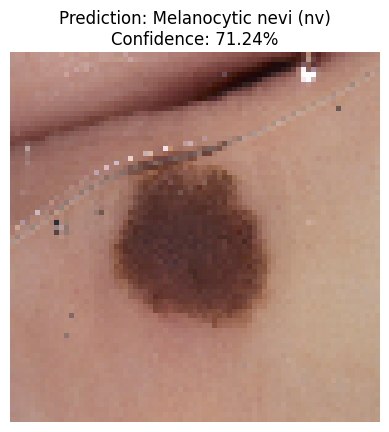

In [4]:
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing import image

# Readable labels for the output
classes = {0: 'Melanocytic nevi (nv)', 1: 'Melanoma (mel)', 2: 'Benign keratosis-like lesions (bkl)',
           3: 'Basal cell carcinoma (bcc)', 4: 'Actinic keratoses (akiec)',
           5: 'Vascular lesions (vasc)', 6: 'Dermatofibroma (df)'}

print("Upload an image of a skin mole/lesion to test:")
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    img_path = fn
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Predict
    classes_pred = model.predict(x)
    prediction = np.argmax(classes_pred)
    confidence = np.max(classes_pred) * 100

    # Show Result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {classes[prediction]}\nConfidence: {confidence:.2f}%")
    plt.show()

In [ ]:
# 1. Install Gradio (The web framework)
!pip install -q gradio

import gradio as gr
import numpy as np
from PIL import Image

# 2. Define the labels (Must match your training data order)
classes = {
    0: 'Melanocytic nevi (nv)',
    1: 'Melanoma (mel)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Basal cell carcinoma (bcc)',
    4: 'Actinic keratoses (akiec)',
    5: 'Vascular lesions (vasc)',
    6: 'Dermatofibroma (df)'
}

# 3. Define the Prediction Function
def predict_skin_lesion(image):
    # Resize the image to match model input (75x75)
    image = image.resize((75, 75))

    # Convert to numpy array
    img_array = np.array(image)

    # Normalize pixel values (0-1) just like in training
    img_array = img_array / 255.0

    # Add batch dimension (1, 75, 75, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)[0]

    # Return dictionary of confidence scores for Gradio
    return {classes[i]: float(prediction[i]) for i in range(7)}

# 4. Build the Web Interface
interface = gr.Interface(
    fn=predict_skin_lesion,
    inputs=gr.Image(type="pil", label="Upload Skin Image"),
    outputs=gr.Label(num_top_classes=3, label="Diagnosis Probability"),
    title="DermAI: Skin Disease Screening",
    description="Upload a clear photo of the skin lesion to analyze visual patterns and potential conditions."
)

# 5. Launch the App
# share=True generates a public link valid for 72 hours
interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://42844418d4107177f6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
